In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from ngsolve.meshes import MakeStructured2DMesh

In [2]:
#hard simply supported plate under load q
L = 1
alpha = pi/(2*L)
q = cos(alpha*x)*cos(alpha*y)

E  = 1e6
nu = 0.3

t  = Parameter(1e-1)
D  = (E*t**3)/(12*(1-nu**2))
k = 5/6
G = E/(2*(1+nu))
C = k*G*t
w_ex = (1/(4*D*alpha**4)+1/(2*C*alpha**2))*cos(alpha*x)*cos(alpha*y)
grad_w_ex =  CF( (w_ex.Diff(x),w_ex.Diff(y)) )
beta_ex = 1/(4*D*alpha**3)*CF( (sin(alpha*x)*cos(alpha*y),cos(alpha*x)*sin(alpha*y)))
curl_beta_ex = beta_ex[1].Diff(x)-beta_ex[0].Diff(y)
grad_beta_ex =  CF( (beta_ex[0].Diff(x),beta_ex[0].Diff(y), beta_ex[1].Diff(x),beta_ex[1].Diff(y)), dims=(2,2) )

mesh = MakeStructured2DMesh(quads=False, nx=8,ny=8, mapping= lambda x,y : (L*(-1+2*x),L*(-1+2*y)))
Draw(w_ex, mesh)
Draw(beta_ex, mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [3]:
def Material(mat):
    return D*((1-nu)*mat+nu*Trace(mat)*Id(2))
def MaterialInv(mat):
    return 1/D*(1/(1-nu)*mat-nu/(1-nu**2)*Trace(mat)*Id(2))

def SolveRM(mesh, order=1, draw=True):
    fesB = VectorH1(mesh, order=order, dirichletx="top|bottom", dirichlety="left|right")
    fesW = H1(mesh, order=order, dirichlet=".*")

    fes = fesW*fesB
    (w,beta), (v,delta) = fes.TnT()
    
    a = BilinearForm(fes, symmetric=True)
    a += InnerProduct(Material(Sym(Grad(beta))),Sym(Grad(delta)))*dx
    a += k*G*t*InnerProduct( grad(w)+beta, grad(v)+delta )*dx

    f = LinearForm(fes)
    f += q*v*dx

    gfsol = GridFunction(fes)
    gfw, gfbeta = gfsol.components
    
    with TaskManager():
        a.Assemble()
        f.Assemble()
        inv = a.mat.Inverse(fes.FreeDofs(), inverse="sparsecholesky")
        gfsol.vec.data = inv * f.vec
    if draw:
        Draw(gfw, mesh, "w")
        Draw(gfbeta, mesh, "w")
    
    return gfw, gfbeta

In [4]:
errW = []
errB = []
ts = [1e-1, 1e-3]
hs = [0.5**i for i in range(1,5)]

order = 2

with TaskManager():
    for thickness in ts:
        t.Set(thickness)
        errW.append([])
        errB.append([])
    
        for h in hs:
            mesh = MakeStructured2DMesh(quads=False, nx=int(L/h),ny=int(L/h), mapping= lambda x,y : (L*(-1+2*x),L*(-1+2*y)))
            gfw, gfbeta = SolveRM(mesh, order=order, draw=True)
        
            w_h1 = sqrt(Integrate(w_ex*w_ex+grad_w_ex*grad_w_ex, mesh))
            beta_h1 = sqrt(Integrate(beta_ex*beta_ex+InnerProduct(grad_beta_ex,grad_beta_ex), mesh))
            errw = sqrt(Integrate((gfw-w_ex)**2+(Grad(gfw)-grad_w_ex)**2,mesh))/w_h1
            errb = sqrt(Integrate((gfbeta-beta_ex)**2+InnerProduct(Grad(gfbeta)-grad_beta_ex,Grad(gfbeta)-grad_beta_ex),mesh))/beta_h1
            errW[-1].append(errw)
            errB[-1].append(errb)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

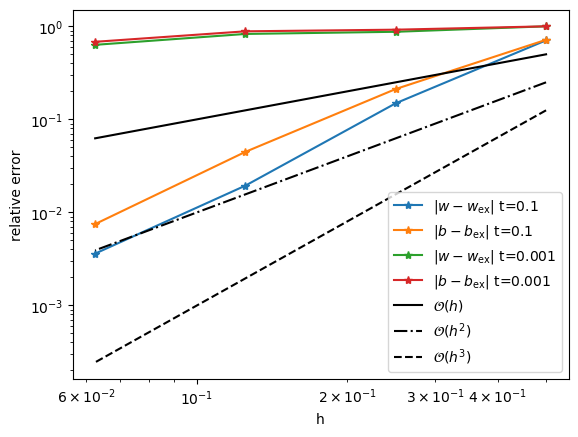

In [5]:
import matplotlib.pyplot as plt

plt.yscale('log')
plt.xscale('log')
plt.xlabel("h")
plt.ylabel("relative error")
for i in range(len(ts)):
    plt.plot(hs,errW[i],"-*", label="$\|w-w_{\mathrm{ex}}\|$ t="+str(ts[i]))
    plt.plot(hs,errB[i],"-*", label="$\|b-b_{\mathrm{ex}}\|$ t="+str(ts[i]))
    
plt.plot(hs,hs,"-",color="k", label="$\mathcal{O}(h)$")
plt.plot(hs,[h**2 for h in hs],"-.",color="k", label="$\mathcal{O}(h^2)$")
plt.plot(hs,[h**3 for h in hs],"--",color="k", label="$\mathcal{O}(h^3)$")
plt.legend()
plt.show()

In [6]:
def SolveRM_TDNNS(mesh, order=1, draw=False):
    fesB = HCurl(mesh, order=order-1, dirichlet=".*")
    fesS = HDivDiv(mesh, order=order-1, dirichlet=".*")
    fesW = H1(mesh, order=order, dirichlet=".*")

    fes = fesW*fesB*fesS
    (w,beta,sigma), (v,delta,tau) = fes.TnT()
    
    n = specialcf.normal(2)
    
    a = BilinearForm(fes, symmetric=True)
    a += (-InnerProduct(MaterialInv(sigma),tau) \
          + InnerProduct(tau,grad(beta)) + InnerProduct(sigma,grad(delta)) -1e-9*beta*delta)*dx
    a += ( -(sigma*n*n)*(delta*n) - (tau*n*n)*(beta*n) )*dx(element_boundary=True)
    a += k*G*t*InnerProduct( grad(w)+beta, grad(v)+delta )*dx

    f = LinearForm(fes)
    f += q*v*dx

    gfsol = GridFunction(fes)
    gfw, gfbeta, gfsigma = gfsol.components
    
    with TaskManager():
        a.Assemble()
        f.Assemble()
        inv = a.mat.Inverse(fes.FreeDofs(), inverse="sparsecholesky")
        gfsol.vec.data = inv * f.vec
    if draw:
        Draw(gfw, mesh, "w")
        Draw(gfbeta, mesh, "w")
    
    return gfw, gfbeta

In [ ]:
errW = []
errB = []
ts = [1e-1, 1e-3]
hs = [0.5**i for i in range(1,5)]

order = 2

with TaskManager():
    for thickness in ts:
        t.Set(thickness)
        errW.append([])
        errB.append([])
    
        for h in hs:
            mesh = MakeStructured2DMesh(quads=False, nx=int(L/h),ny=int(L/h), mapping= lambda x,y : (L*(-1+2*x),L*(-1+2*y)))
            gfw, gfbeta = SolveRM_TDNNS(mesh, order=order, draw=False)
        
            w_h1 = sqrt(Integrate(w_ex*w_ex+grad_w_ex*grad_w_ex, mesh))
            beta_hc = sqrt(Integrate(beta_ex*beta_ex+curl_beta_ex*curl_beta_ex, mesh))
            errw = sqrt(Integrate((gfw-w_ex)**2+(Grad(gfw)-grad_w_ex)**2,mesh))/w_h1
            errb = sqrt(Integrate((gfbeta-beta_ex)**2+(curl(gfbeta)-curl_beta_ex)**2,mesh))/beta_hc
            errW[-1].append(errw)
            errB[-1].append(errb)

In [ ]:
import matplotlib.pyplot as plt

plt.yscale('log')
plt.xscale('log')
plt.xlabel("h")
plt.ylabel("relative error")
for i in range(len(ts)):
    plt.plot(hs,errW[i],"-*", label="$\|w-w_{\mathrm{ex}}\|$ t="+str(ts[i]))
    plt.plot(hs,errB[i],"-*", label="$\|b-b_{\mathrm{ex}}\|$ t="+str(ts[i]))
    
plt.plot(hs,hs,"-",color="k", label="$\mathcal{O}(h)$")
plt.plot(hs,[h**2 for h in hs],"-.",color="k", label="$\mathcal{O}(h^2)$")
plt.plot(hs,[h**3 for h in hs],"--",color="k", label="$\mathcal{O}(h^3)$")
plt.legend()
plt.show()